Fraud detection sklearn stratified (unbalanced classes)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from IPython.display import Image

from sklearn import metrics
from collections import Counter

To combat class imbalance, there are many techniques:
- More samples from the minority class(es) should be acquired from the knowledge domain.
- Changing the loss function to give the failing minority class a higher cost.
- Oversampling the minority class.
- Undersampling the majority class.
- Any combination of previous approaches.several techniques:


Oversampling the minority class is the most often used approach (but not necessarily the best)
- duplicate or create new synthetic examples in the minority class

Consider the case of an imbalanced dataset with a 1:100 class imbalance. Blind guess will give us a 99% accuracy score (by betting on majority class).

The rule of thumb is: accuracy never helps in imbalanced dataset.

In [2]:
# Read in data
raw_df = pd.read_csv('creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

No null data

In [4]:
raw_df.shape

(284807, 31)

The dataset above contains credit card transactions that occured in 2 days, where we have 492 frauds out of 284,807 transactions. <br>
The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions

## Data Imbalance Check

In [5]:
labels=["Genuine","Fraud"]

# fraud_or_not = raw_df["Class"].value_counts().tolist()
# values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=raw_df['Class'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["skyblue","black"]
             ,title="Fraud vs Genuine transactions")
fig.show()

Don't use accuracy score as a metric with imbalanced datasets - it will be usually high and misleading.

We can assume that the PCA features are scaled, except for 'time' and 'amount'

In [6]:
# Create dataframe copy
df = raw_df.copy()

In [7]:
# Drop duplicated values
df.drop_duplicates(inplace=True)

In [8]:
# drop time column
df = df.drop('Time', axis=1)

## Check for outliers:

In [9]:
numeric_columns = (list(df.loc[:, 'V1':'Amount']))
#numeric_columns.head()

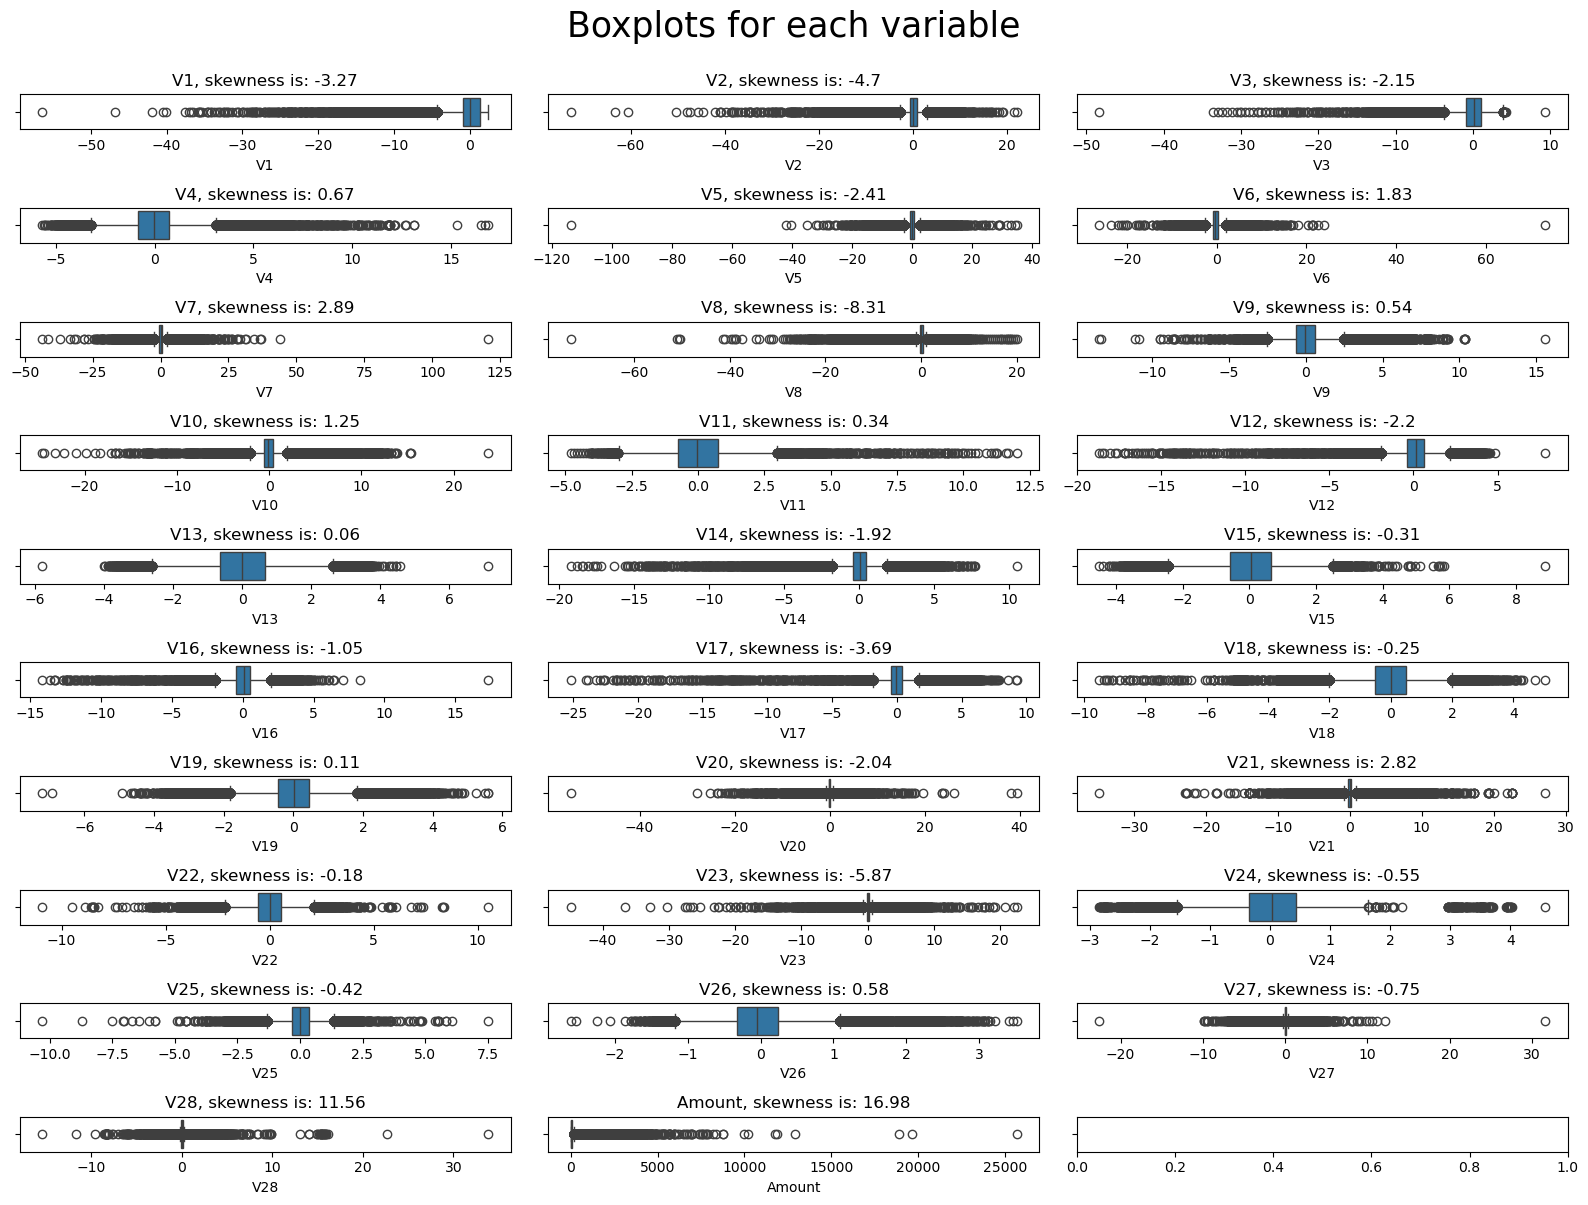

In [10]:
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(16,12))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
        
boxplots_custom(dataset=df, columns_list=numeric_columns, rows=10, cols=3, suptitle='Boxplots for each variable')
plt.tight_layout()
plt.show()


There are many outliers present. We can't drop them since many of them may be the fraud transactions that we need for training.

## Train Test Split

**Stratified splitting** means that when you generate a training / validation dataset split, it will attempt to keep the same percentages of classes in each split. <br><br>
This splitting is random, but the problem is that the proportions of the target variable among the different splits can differ, especially in the case of small datasets.

In [11]:
X = df.drop('Class', axis=1)
y = df['Class']

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [45]:
y_train.sum()

331

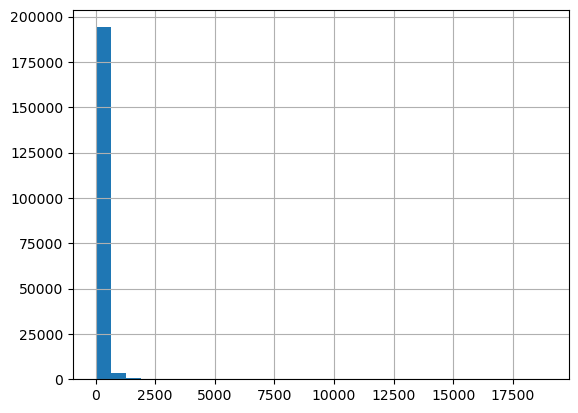

In [13]:
X_train['Amount'].hist(bins=30)
plt.show()

Remember to split into train and test sets BEFORE trying oversampling/undersamping techniques.

## Feature Scaling

In [14]:
from sklearn.preprocessing import StandardScaler

# Create function for scaling specified columns
def standard_scaler(df, col_names):
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features

    return df

In [15]:
col_names = ['Amount']
X_train = standard_scaler(X_train, col_names)
X_test = standard_scaler(X_test, col_names)

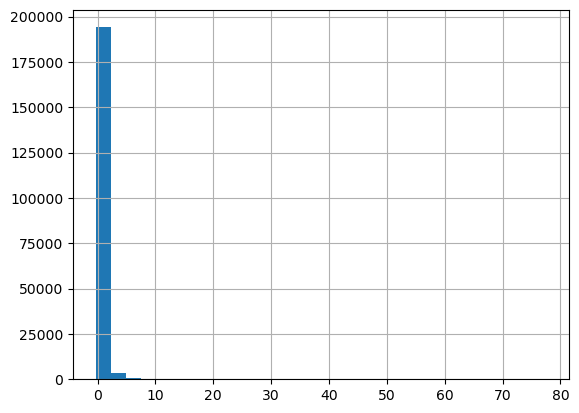

In [16]:
X_train['Amount'].hist(bins=30)
plt.show()

## Stratified Cross-Validation

The best model is not the one that gives accurate predictions on the training data, but the one which gives good predictions on the new data and avoids overfiting and underfitting.<br><br>

Cross-Validation is a resampling procedure used to evaluate ML models on a limited data sample. The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation.<br><br>

The purpose of k-fold cross-validation is to test the ability of a ML model to predict new data.

**Stratified cross-validation**: Used when the datasets contain unbalanced classes. Therefore if we cross-validate with a normal technique, it may produce subsamples that have a varying distribution of classes. Some unbalanced classes may produce exceptionally high scores leading to a high cross-validation score overall, which is undesirable. <br>

Therefore, we create stratified subsamples that preserve the class frequencies in the individual folds to ensure that we are able to get a clear picture of the model performance. 

### Oversample / Undersample and Cross Validation

If you want to undersample or oversample your data you shouldn't do it before cross validating because you will be directly influencing the validation set before implementing cross-validation without causing a "data leakage" problem. <br>

We should do both feature selection and oversampling inside the cross validation loop

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# We are going to ensure that we have the same splits of the data every time. 
# We can ensure this by creating a KFold object, kf, and passing cv=kf instead of the more common cv=5

kf = StratifiedKFold(n_splits=5, shuffle=False)

In [18]:
rf = RandomForestClassifier(n_estimators=100, random_state=13)

### Optimizing for Recall

Recall is the proportion of positive labels that were correctly identified by the model. In high-risk cases like cancer, recall is more important than precision.<br>

For credit card fraud detection, we want to avoid false negatives as much as possible (AKA we fail to capture fraud). 

In [19]:
score = cross_val_score(rf, X_train, y_train, cv=kf, scoring='recall', n_jobs=-1) # evaluate revall scores for each of the 5 stratified folds
print("Cross validation scores are: {}".format(score))
print("Average Cross validation recall score: {}".format(score.mean()))

Cross validation scores are: [0.8030303  0.74242424 0.76119403 0.87878788 0.65151515]
Average Cross validation recall score: 0.7673903211216644


### When is precision more important than recall?

When a False Positive is very costly, and a False Negative not as much.

## Hyperparameter Tuning using GridSearchCV

GridSearchCV is a technique for finding the optimal hyperparameter values from a given set of parameters in a grid. It's essentially a cross-validation technique. <br>

The model as well as the hyperparameters to be tested must be entered. After extracting the best hyperparameter values, predictions are made. <br>

In [20]:
from sklearn.model_selection import GridSearchCV

# # Takes too long to run
# params = {
#     'n_estimators' : [100],
#     'max_depth' : [6, 12],
#     'random_state':[13]
# }

# grid_rf = GridSearchCV(rf, param_grid=params, cv=kf, scoring='recall', n_jobs=-1).fit(X_train, y_train)

In [21]:
# print('Best parameters:', grid_rf.best_params_) # Just use 100 estimators and use 12 estimators
# print('Best score:', grid_rf.best_score_)

In [22]:
from sklearn.metrics import recall_score

# rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=13)
# rf_classifier.fit(X_train, y_train)
# y_pred = rf_classifier.predict(X_test)
# recall = recall_score(y_test, y_pred)
# print("Recall Score:", recall)

In [23]:
rf_classifier_2 = RandomForestClassifier(random_state=13)
rf_classifier_2.fit(X_train, y_train)
y_pred = rf_classifier_2.predict(X_test)
recall = recall_score(y_test, y_pred)
print("Recall Score:", recall)

Recall Score: 0.7676056338028169


In [48]:
pd.Series(y_pred).value_counts()

0    84814
1      304
Name: count, dtype: int64

We have about 77% recall on one of our models before we oversample. Let's check the test set scores:

In [24]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[84972     4]
 [   33   109]]


In [25]:
rf_Recall = recall_score(y_test, y_pred)
rf_Precision = precision_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)
rf_accuracy = accuracy_score(y_test, y_pred)

ndf = [(rf_Recall, rf_Precision, rf_f1, rf_accuracy)]

rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_score.insert(0, 'Random Forest with', 'No Under/Oversampling')
rf_score

,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,No Under/Oversampling,0.767606,0.964602,0.854902,0.999565


The resulting recall score is 77%. We will try to beat it. 

### Imbalanced-Learn pipeline

The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.<br>

During the cross-validation process, we should split into training and validation segments. Then, on each segment, we should:
1. Oversample the minority class
2. Train the classifier on the training segment
3. Validate the classifier on the remaining segment

Pipeline is a great way to do this in a smart way. <br>

The imblearn package implements its own pipeline to with extra functions for transforming and sampling

In [26]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import RandomOverSampler

# imblearn pipeline for oversampling
random_overs_pipeline = make_pipeline(RandomOverSampler(random_state=42), RandomForestClassifier(random_state=13))

In [28]:
score2 = cross_val_score(random_overs_pipeline, X_train, y_train, scoring='recall', cv=kf, n_jobs=-1)
print("Cross Validation Recall Scores are: {}".format(score2))
print("Average Cross Validation Recall score: {}".format(score2.mean()))

Cross Validation Recall Scores are: [0.83333333 0.72727273 0.74626866 0.86363636 0.65151515]
Average Cross Validation Recall score: 0.7644052464947987


The score is actualy worse, this may be due to overfitting due to duplicate minority class records

In [30]:
params = {
    'randomforestclassifier__n_estimators' : [50, 100],
    'randomforestclassifier__max_depth' : [6, 12],
    'randomforestclassifier__random_state':[13]
}

grid_over_rf = GridSearchCV(random_overs_pipeline, param_grid=params, cv=kf, scoring='recall',
                        return_train_score=True, n_jobs=-1)
grid_over_rf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('randomoversampler',
                                        RandomOverSampler(random_state=42)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=13))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [6, 12],
                         'randomforestclassifier__n_estimators': [50, 100],
                         'randomforestclassifier__random_state': [13]},
             return_train_score=True, scoring='recall')

In [31]:
print('Best parameters:', grid_over_rf.best_params_)
print('Best score:', grid_over_rf.best_score_) # recall score improved

Best parameters: {'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__random_state': 13}
Best score: 0.8429669832654907


In [32]:
# Get the training and test accuracy
train_accuracy = grid_over_rf.cv_results_['mean_train_score'][grid_over_rf.best_index_]
test_accuracy = grid_over_rf.cv_results_['mean_test_score'][grid_over_rf.best_index_]

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.9645082904516867
Test Accuracy: 0.8429669832654907


In [33]:
y_pred = grid_over_rf.predict(X_test)
recall = recall_score(y_test, y_pred)
print("Recall Score:", recall)

Recall Score: 0.8169014084507042


In [36]:
type(grid_over_rf)

sklearn.model_selection._search.GridSearchCV

In [38]:
best_rf = grid_over_rf.best_estimator_
type(best_rf)

imblearn.pipeline.Pipeline

In [39]:
best_rf.named_steps

{'randomoversampler': RandomOverSampler(random_state=42),
 'randomforestclassifier': RandomForestClassifier(max_depth=6, n_estimators=50, random_state=13)}

In [40]:
rf_classifier = best_rf.named_steps['randomforestclassifier']

In [41]:
rf_classifier.feature_importances_

array([0.00802538, 0.00396929, 0.03114018, 0.12583045, 0.0056436 ,
       0.0083529 , 0.01764419, 0.00624388, 0.0071867 , 0.19364539,
       0.04376915, 0.17515286, 0.00235058, 0.17775674, 0.00294462,
       0.00595279, 0.13211864, 0.00415943, 0.00655659, 0.00600741,
       0.00965989, 0.00718895, 0.00161098, 0.00130334, 0.00109664,
       0.00402488, 0.00201716, 0.00333956, 0.0053078 ])

In [42]:
rf_classifier.feature_names_in_

array(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype=object)

## Get Feature Importances:

In [43]:
d = {'features':rf_classifier.feature_names_in_,
     'importances':rf_classifier.feature_importances_}
pd.DataFrame(data=d).sort_values(by='importances', ascending=False)

,features,importances
9,V10,0.193645
13,V14,0.177757
11,V12,0.175153
16,V17,0.132119
3,V4,0.125830
10,V11,0.043769
2,V3,0.031140
6,V7,0.017644
20,V21,0.009660
5,V6,0.008353


In [44]:
# best_rf.predict(X_test)
y_pred = best_rf.predict(X_test)
recall = recall_score(y_test, y_pred)
print("Recall Score:", recall)

Recall Score: 0.8169014084507042
